<a href="https://colab.research.google.com/github/krishnanravi03/convolution-nueral-networks/blob/main/AI_Project_Inception_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import copy
from sklearn.metrics import classification_report

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [54]:
data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [55]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data',train=True,transform=data_transform,download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data',train=False,transform=data_transform, download=True)
train_size = int(len(train_dataset) * 0.9) # 80% training data
valid_size = len(train_dataset) - train_size # 20% validation data
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

In [56]:
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

torch.Size([20, 1, 224, 224]) torch.Size([20])


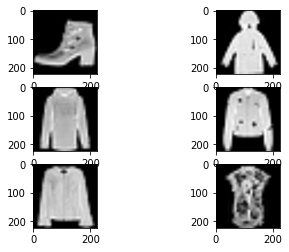

In [57]:
value = iter(val_loader)
value_data, value_label = next(value)

for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(value_data[i][0], cmap='gray')
plt.show()

In [63]:
def Conv2dLayer(in_channels, out_channels, kernel_size, **kwargs):
  return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, **kwargs),
            nn.BatchNorm2d(out_channels), 
            nn.ReLU()
        )

class InceptionModule(nn.Module):
    def __init__(self, in_channels, filers_1x1, filters_3x3_reduce, filers_3x3, filters_5x5_reduce, filters_5x5, filters_pool_projection):
        super(InceptionModule, self).__init__()
        self.conv1x1 = Conv2dLayer(in_channels, filers_1x1, kernel_size=1)
        self.conv3x3_reduce = Conv2dLayer(in_channels, filters_3x3_reduce, kernel_size=1)  
        self.conv3x3 = Conv2dLayer(filters_3x3_reduce, filers_3x3, kernel_size=3, padding=1)
        self.conv5x5_reduce = Conv2dLayer(in_channels, filters_5x5_reduce, kernel_size=1)
        self.conv5x5 = Conv2dLayer(filters_5x5_reduce, filters_5x5, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_projection = Conv2dLayer(in_channels, filters_pool_projection, kernel_size=1)
         
    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3_reduce(x)
        x2 = self.conv3x3(x2)
        x3 = self.conv5x5_reduce(x)
        x3 = self.conv5x5(x3)
        x4 = self.maxpool(x)
        x4 = self.pool_projection(x4)
        x = torch.cat([x1, x2, x3, x4], 1)
        return x

class InceptionModule(nn.Module):
    def __init__(self, in_channels, filers_1x1, filters_3x3_reduce, filers_3x3, filters_5x5_reduce, filters_5x5, filters_pool_projection):
        super(InceptionModule, self).__init__()
        self.conv1x1 = Conv2dLayer(in_channels, filers_1x1, kernel_size=1)
        self.conv3x3_reduce = Conv2dLayer(in_channels, filters_3x3_reduce, kernel_size=1)  
        self.conv3x3 = Conv2dLayer(filters_3x3_reduce, filers_3x3, kernel_size=3, padding=1)
        self.conv5x5_reduce = Conv2dLayer(in_channels, filters_5x5_reduce, kernel_size=1)
        self.conv5x5 = Conv2dLayer(filters_5x5_reduce, filters_5x5, kernel_size=5, padding=2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_projection = Conv2dLayer(in_channels, filters_pool_projection, kernel_size=1)
         
    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3_reduce(x)
        x2 = self.conv3x3(x2)
        x3 = self.conv5x5_reduce(x)
        x3 = self.conv5x5(x3)
        x4 = self.maxpool(x)
        x4 = self.pool_projection(x4)
        x = torch.cat([x1, x2, x3, x4], 1)
        return x

class Inception(nn.Module):
    def __init__(self, in_channels, output_classes):
        super(Inception, self).__init__()
        self.convLayer1 = Conv2dLayer(in_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.convlayer2 = Conv2dLayer(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(1024, output_classes)

        self.inceptionLayer3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inceptionLayer3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.inceptionLayer4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inceptionLayer4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inceptionLayer4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inceptionLayer4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inceptionLayer4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.inceptionLayer5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inceptionLayer5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        x = self.convLayer1(x)
        x = self.maxpool(x)
        x = self.convlayer2(x)
        x = self.maxpool(x)
        x = self.inceptionLayer3a(x)
        x = self.inceptionLayer3b(x)
        x = self.maxpool(x)
        x = self.inceptionLayer4a(x)
        x = self.inceptionLayer4b(x)
        x = self.inceptionLayer4c(x)
        x = self.inceptionLayer4d(x)
        x = self.inceptionLayer4e(x)
        x = self.maxpool(x)
        x = self.inceptionLayer5a(x)
        x = self.inceptionLayer5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.linear(x)      
        return x

In [65]:
input_size = 227*227*1 # as the image is of size 28X28X1, 1 - grey scale, and input will have 28*28 sized input array
batch_size = 200
num_of_labels = 10
epochs = 5
learning_rate = 0.001
model = Inception(in_channels=1, output_classes=num_of_labels)
model.to(device)
next(model.parameters()).is_cuda

True

In [66]:
model

Inception(
  (convLayer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convlayer2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=1024, out_features=10, bias=True)
  (inceptionLayer3a): InceptionModule(
    (conv1x1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3x3_reduce): Sequential(
      (0): Conv2d(192, 96, kerne

In [71]:
def train(model, dataloaders, num_of_epochs=5):
  start_time = time.time()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
  lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
  training_losses = []
  validation_losses = []
  training_accuracies = []
  validation_accuracies = []
  best_model_so_far = copy.deepcopy(model.state_dict())
  best_accuracy_so_far = 0.0
  phases = ['train', 'validation']

  for epoch in range(num_of_epochs):
    for phase in phases:
      if phase == 'train':
          model.train()
      else:
          model.eval()
      loss_so_far = 0.0
      correct_predictions_so_far = 0
      for inputs, labels in dataloaders[phase]:          
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            if phase == 'train':
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predictions = torch.max(outputs, 1)
                loss.backward()
                optimizer.step()
            if phase == 'validation':
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predictions = torch.max(outputs, 1)

        loss_so_far += loss.item() * inputs.size(0)
        correct_predictions_so_far += torch.sum(predictions == labels.data)

      loss_for_epoch = loss_so_far / len(dataloaders[phase].dataset)
      if phase == 'validation': 
          lr_scheduler.step(loss_for_epoch)
      accuracy_for_epoch = correct_predictions_so_far.double() / len(dataloaders[phase].dataset)


      print('Epoch {}/{}'.format(epoch, num_of_epochs - 1))
      print('-----------------------')
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, loss_for_epoch, accuracy_for_epoch))

      if phase == 'validation' and accuracy_for_epoch > best_accuracy_so_far:
        best_accuracy_so_far = accuracy_for_epoch
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'validation':
        validation_accuracies.append(accuracy_for_epoch.item())
        validation_losses.append(loss_for_epoch)
      if phase == 'train':
        training_accuracies.append(accuracy_for_epoch.item())
        training_losses.append(loss_for_epoch)
      print()

  time_taken = time.time() - start_time
  print('Time taken for training {:.0f}m {:.0f}s'.format(time_taken // 60, time_taken % 60))
  model.load_state_dict(best_model_so_far)
  return model, training_losses, training_accuracies, validation_losses, validation_accuracies

In [ ]:
def testmodel(mode, test_loader):
  with torch.no_grad():
    correct_predictions = 0
    no_of_samples = 0
    for indx, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      input_labels = labels.to(device)
      outputs= model(inputs)
      _, predictions = torch.max(outputs, 1)
      correct_predictions += (predictions == input_labels).sum().item()
      no_of_samples += input_labels[0]
  return classification_report(input_labels, predictions)

In [72]:
data_loaders = {"train": train_loader, "validation": val_loader}
model, training_losses_mnist, training_accuracies_mnist, validation_losses_mnist, validation_accuracies_mnist = train(model, data_loaders)

KeyboardInterrupt: ignored

In [ ]:
print("Results for MNIST dataset")
print("====================================")
print(training_loss)
print(training_acc)
print(validation_loss)
print(validation_acc)

[1.3145539567426399, 0.446811823270939, 0.35963819534690294, 0.3050918728665069, 0.2655753078560034]
[0.8208518518518518, 0.9083333333333333, 0.9257592592592593, 0.9364814814814815, 0.9462592592592592]
[0.3616572211186091, 0.253979862233003, 0.255289526283741, 0.24334580153226854, 0.21358141054709753]
[tensor(0.8713, device='cuda:0', dtype=torch.float64), tensor(0.9098, device='cuda:0', dtype=torch.float64), tensor(0.9045, device='cuda:0', dtype=torch.float64), tensor(0.9172, device='cuda:0', dtype=torch.float64), tensor(0.9243, device='cuda:0', dtype=torch.float64)]


Test Accuracy: 91.41


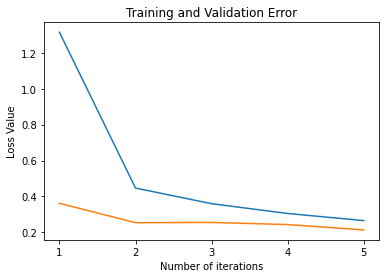

In [ ]:
epochs = [1, 2, 3, 4, 5]
plt.plot(epochs, training_loss)
plt.plot(epochs, validation_loss)
plt.xticks(epochs)
plt.xlabel("Number of iterations")
plt.ylabel("Loss Value")
plt.title("Training and Validation Error")
plt.show()

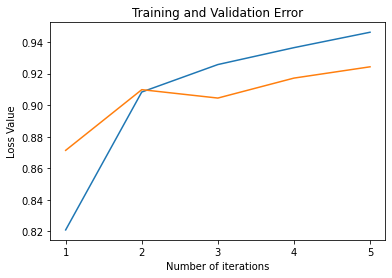

In [ ]:
del model
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
model = None
gc.collect()

NameError: ignored